In [2]:
import glob
import os
import librosa
from librosa import display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
%matplotlib inline
plt.style.use('ggplot')


plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['figure.titlesize'] = 13

In [3]:
def windows(audio_size, window_size, stride_size):
    start = 0
    while start < audio_size:
        yield int(start), int(start + window_size)
        start += stride_size

def extract_mfccs(X, sample_rate, num_stride=100, num_mfcc=40):
    
    mfccs = []
    
    audio_size = X.size
    stride_size = int(audio_size / num_stride)
    window_size = 3 * stride_size
    
    for (start,end) in windows(audio_size, window_size, stride_size):
        if len(X[start:end]) != window_size:
            continue
        mfcc = np.mean(librosa.feature.mfcc(y=X[start:end], sr=sample_rate, n_mfcc=num_mfcc).T, axis=0)
        
        mfccs.append(mfcc)
    
    return np.array(mfccs).T

def extract_feature(file_name):
    
    X, sample_rate = librosa.load(file_name, sr=None, mono=True)
    mfcc = librosa.feature.mfcc(X, sample_rate, n_mfcc=40)
    
    mfcc = np.pad(mfcc,((0, 0),(0, 32-mfcc.shape[1])), mode='constant', constant_values=0)
#     return extract_mfccs(X, sample_rate)
    
    return mfcc


In [150]:
file_folder = './dataset_tmp'


sound_file_names = ["0a9f9af7_nohash_2.wav",
                    "0ab3b47d_nohash_1.wav",
                    "0ac15fe9_nohash_0.wav",
                    "0ab3b47d_nohash_0.wav",
                    "0ab3b47d_nohash_1.wav"]

sound_class_names = ["down","go","left","right","up"]

sound_file_paths = list(map(lambda f_tup: os.path.join(file_folder, f_tup[0], f_tup[1]), 
                            zip(sound_class_names, sound_file_names)))

print(sound_file_paths)

['./dataset_tmp/down/0a9f9af7_nohash_2.wav', './dataset_tmp/go/0ab3b47d_nohash_1.wav', './dataset_tmp/left/0ac15fe9_nohash_0.wav', './dataset_tmp/right/0ab3b47d_nohash_0.wav', './dataset_tmp/up/0ab3b47d_nohash_1.wav']


(40, 32)
(40, 32)
(40, 32)
(40, 32)
(40, 32)


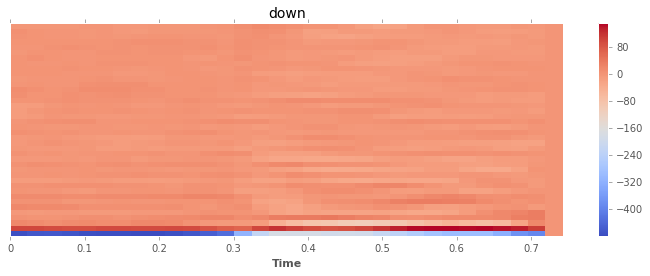

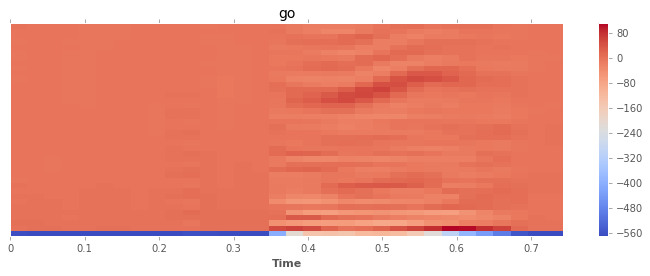

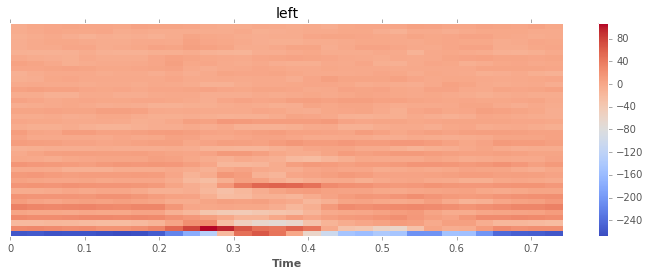

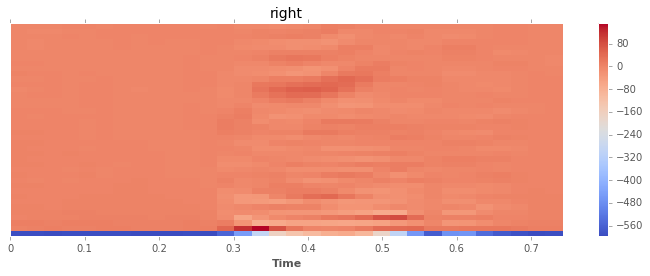

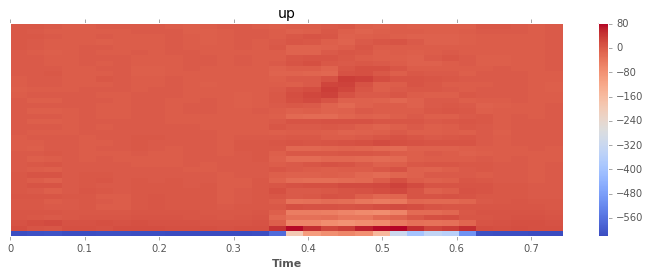

In [343]:
def plot_mfccs(file_paths):
    for idx, file_path in enumerate(file_paths):
        mfccs_with_strides = extract_feature(file_path)
        print(mfccs_with_strides.shape)
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(mfccs_with_strides, x_axis='time')
        plt.colorbar()
        plt.title(sound_class_names[idx])
        plt.tight_layout()
        plt.savefig(sound_class_names[idx])

plot_mfccs(sound_file_paths)

In [10]:
class_labels = {
    'down'   : 0,
    'left'   : 1,
    'off'    : 2,
    'on'     : 3,
    'right'  : 4,
    'up'     : 5
}

def parse_audio_files(parent_dir, sub_dirs, file_ext='*.wav'):
    
    features, labels = np.empty((0, 40 * 32)), []
    for sub_dir in sub_dirs:
        
        print("Working on %s" % sub_dir)

        for file_cnt, fn in enumerate(glob.glob(os.path.join(parent_dir, sub_dir, file_ext))):
            
            if file_cnt > 0 and file_cnt % 200 is 0:
                print('Processed %d files' % file_cnt)
                
            mfccs = extract_feature(fn)
            
            features = np.vstack([features, mfccs.reshape((1, -1))])
            labels.append(class_labels[sub_dir])
            
    return np.array(features), np.array(labels, dtype = np.int)

parent_dir = 'dataset'

sub_dirs = ['down','left', 'off', 'on', 'right', 'up']

features, labels = parse_audio_files(parent_dir, sub_dirs)

Working on down
Processed 200 files
Processed 400 files
Processed 600 files
Processed 800 files
Processed 1000 files
Processed 1200 files
Processed 1400 files
Processed 1600 files
Processed 1800 files
Processed 2000 files
Processed 2200 files
Working on left
Processed 200 files
Processed 400 files
Processed 600 files
Processed 800 files
Processed 1000 files
Processed 1200 files
Processed 1400 files
Processed 1600 files
Processed 1800 files
Processed 2000 files
Processed 2200 files
Working on off
Processed 200 files
Processed 400 files
Processed 600 files
Processed 800 files
Processed 1000 files
Processed 1200 files
Processed 1400 files
Processed 1600 files
Processed 1800 files
Processed 2000 files
Processed 2200 files
Working on on
Processed 200 files
Processed 400 files
Processed 600 files
Processed 800 files
Processed 1000 files
Processed 1200 files
Processed 1400 files
Processed 1600 files
Processed 1800 files
Processed 2000 files
Processed 2200 files
Working on right
Processed 200 

In [13]:
print(features.shape)
print(labels.shape)

(14178, 1280)
(14178,)


In [14]:
np.savetxt("nn_simple_features.csv", features, delimiter=",")
np.savetxt("nn_simple_labels.csv", labels, delimiter=",")

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse=False)

X_all = features
y_all = enc.fit_transform(labels.reshape(-1, 1))
print(X_all.shape)
print(y_all.shape)

(14178, 1280)
(14178, 6)


In [41]:
X_not_test, X_test, y_not_rest, y_test = train_test_split(
    X_all, y_all, stratify=labels, train_size=.85)

X_train, X_val, y_train, y_val = train_test_split(
    X_not_test, y_not_rest, stratify=y_not_rest, train_size=.95)

/home/admin/anaconda3/envs/py35deeplearning/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [42]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(11448, 1280)
(11448, 6)
(603, 1280)
(603, 6)
(2127, 1280)
(2127, 6)


In [335]:
# Parameters
learning_rate = 0.001
training_iters = 1500000
batch_size = 128
display_step = 10

# Network Parameters
n_input = 1216
n_classes = 6
dropout = 0.5 # Dropout, probability to keep units

# tf Graph input
x = tf.placeholder(tf.float32, [None, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])
keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)

In [336]:
def feed_next_batch(train_size, batch_size=64):
    
    start = 0
    while start < train_size:
        yield start, start + batch_size
        start += batch_size

In [337]:
# Create model
def build_model(x, weights, biases, dropout):


    # Reshape input picture
#     x = tf.reshape(x, shape=[-1, 40, 32, 1])
    
#     # Convolution Layer
#     conv1 = conv2d(x, weights['wc1'], biases['bc1'])
#     # Max Pooling (down-sampling)
#     conv1 = maxpool2d(conv1, k=2)
# #     conv1 = tf.nn.dropout(conv1, 0.2)
    
#     # Convolution Layer
#     conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
#     # Max Pooling (down-sampling)
#     conv2 = maxpool2d(conv2, k=2)
# #     conv2 = tf.nn.dropout(conv2, 0.5)
#     conv3 = conv2d(conv2, weights['wc3'], biases['bc3'])
#     # Max Pooling (down-sampling)
#     conv3 = maxpool2d(conv3, k=2)
    
#     # Fully connected layer
#     # Reshape conv2 output to fit fully connected layer input
#     fc1 = tf.reshape(conv3, [-1, weights['wd1'].get_shape().as_list()[0]])

    fc1 = tf.add(tf.matmul(x, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    
    fc2 = tf.add(tf.matmul(fc1, weights['wd2']), biases['bd2'])
    fc2 = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, 0.8)
    
    fc3 = tf.add(tf.matmul(fc2, weights['wd3']), biases['bd3'])
    fc3 = tf.nn.relu(fc3)
    # Apply Dropout
    fc3 = tf.nn.dropout(fc3, 0.5)

    # Output, class prediction
    out = tf.add(tf.matmul(fc3, weights['out']), biases['out'])
    return out

In [338]:
# Store layers weight & bias
weights = {
    # 5x5 conv, 1 input, 32 outputs
    'wc1': tf.Variable(tf.random_normal([5, 5, 1, 32])),
    # 5x5 conv, 32 inputs, 64 outputs
    'wc2': tf.Variable(tf.random_normal([3, 3, 32, 64])),
    
    'wc3': tf.Variable(tf.random_normal([3, 3, 64, 128])),
    # fully connected, 7*7*64 inputs, 1024 outputs
#     'wd1': tf.Variable(tf.random_normal([5 * 4 * 128, 256])),
    'wd1': tf.Variable(tf.random_normal([n_input, 1024])),
    'wd2': tf.Variable(tf.random_normal([1024, 512])),
    'wd3': tf.Variable(tf.random_normal([512, 1024])),
#     'wd4': tf.Variable(tf.random_normal([1024, 1024])),
    # 1024 inputs, 10 outputs (class prediction)
    'out': tf.Variable(tf.random_normal([1024, n_classes]))
}

biases = {
    'bc1': tf.Variable(tf.random_normal([32])),
    'bc2': tf.Variable(tf.random_normal([64])),
    'bc3': tf.Variable(tf.random_normal([128])),
    
    'bd1': tf.Variable(tf.random_normal([1024])),
    'bd2': tf.Variable(tf.random_normal([512])),
    'bd3': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

# Construct model
pred = build_model(x, weights, biases, keep_prob)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initializing the variables
init = tf.global_variables_initializer()

In [339]:
# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    step = 1
    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        
        X_train_tmp, y_train_tmp = X_train, y_train
        
        for start, end in feed_next_batch(len(X_train_tmp), batch_size=batch_size):
            
            batch_x, batch_y = X_train_tmp[start:end], y_train_tmp[start:end]
            
            # Run optimization op (backprop)
            sess.run(optimizer, feed_dict={x: batch_x, y: batch_y,
                                       keep_prob: dropout})
            if step % display_step == 0:
                # Calculate batch loss and accuracy
                loss, acc = sess.run([cost, accuracy], feed_dict={x: batch_x,
                                                          y: batch_y,
                                                          keep_prob: 1.})
                print ("Iter " + str(step*batch_size) + ", Minibatch Loss= " + \
                      "{:.6f}".format(loss) + ", Training Accuracy= " + \
                      "{:.5f}".format(acc))
                
                print ("Accuracy on Validation Set:", \
                        sess.run(accuracy, feed_dict={x: X_val,
                                      y: y_val,
                                      keep_prob: 1.}))
                print('-' * 60)
            
            step += 1
            
    print ("Optimization Finished!")

    # Calculate accuracy for 256 mnist test images
    print ("Testing Accuracy:", \
        sess.run(accuracy, feed_dict={x: X_test,
                                      y: y_test,
                                      keep_prob: 1.}))

Iter 1280, Minibatch Loss= 29751.474609, Training Accuracy= 0.26562
Accuracy on Validation Set: 0.202783
------------------------------------------------------------
Iter 2560, Minibatch Loss= 28883.414062, Training Accuracy= 0.19531
Accuracy on Validation Set: 0.228628
------------------------------------------------------------
Iter 3840, Minibatch Loss= 22885.875000, Training Accuracy= 0.27344
Accuracy on Validation Set: 0.260437
------------------------------------------------------------
Iter 5120, Minibatch Loss= 19457.361328, Training Accuracy= 0.33594
Accuracy on Validation Set: 0.274354
------------------------------------------------------------
Iter 6400, Minibatch Loss= 20183.789062, Training Accuracy= 0.22656
Accuracy on Validation Set: 0.274354
------------------------------------------------------------
Iter 7680, Minibatch Loss= 18163.339844, Training Accuracy= 0.29688
Accuracy on Validation Set: 0.290258
------------------------------------------------------------
Iter

In [341]:
features.shape

(11826, 1280)